In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['platesv2']


In [2]:
import shutil 
import cv2
from tqdm import tqdm


import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from PIL import Image
from torchvision import transforms, models

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [4]:
data_root = '../input/platesv2/plates/plates/'
print(os.listdir(data_root))

['test', 'train']


In [5]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        dest_dir = os.path.join(train_dir, class_name) 
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 20/20 [00:00<00:00, 688.06it/s]


In [6]:
!ls train

cleaned  dirty


In [7]:
pip install knockknock

     |████████████████████████████████| 389kB 5.1MB/s 
     |████████████████████████████████| 358kB 38.8MB/s 
     |████████████████████████████████| 491kB 47.5MB/s 
  Created wheel for twilio: filename=twilio-6.32.0-py2.py3-none-any.whl size=1033049 sha256=c5c16d3a946d9de5eef107c9f0b585052e119f3acdb15f8fd8388f59d2af29e8
  Stored in directory: /tmp/.cache/pip/wheels/94/3c/0e/049f913544f4f0d5c57e6d2fb6e39781d35b894c8b2f261bd0
  Created wheel for tornado: filename=tornado-6.0.3-cp36-cp36m-linux_x86_64.whl size=423332 sha256=3dd1d2af3aa6fd09d3665127fdf6281228283c1cdb243b0e27ff0c078909189c
  Stored in directory: /tmp/.cache/pip/wheels/84/bf/40/2f6ef700f48401ca40e5e3dd7d0e3c0a90e064897b7fe5fc08
Successfully built twilio tornado
  Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
Note: you may need to restart the kernel to use updated packages.


In [8]:
import knockknock

In [9]:
from knockknock import telegram_sender

CHAT_ID: int = 266478885
@telegram_sender(token="647225942:AAF-biI_UdXDVOwhqBjFRcELwbTzdeidn0w", chat_id=CHAT_ID)
def train_your_nicest_model(time_value=2):
    import time
    time.sleep(time_value)
    return {'loss': 0.9} # Optional return value

In [10]:
train_your_nicest_model()

{'loss': 0.9}

In [11]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize((224,224)),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.Grayscale(3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize((224,224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
#val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 20
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
#val_dataloader = torch.utils.data.DataLoader(
#    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [12]:
len(train_dataloader), len(train_dataset)

(2, 40)

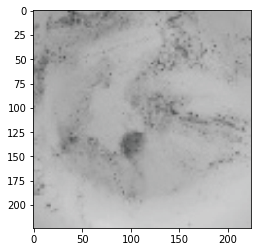

In [13]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

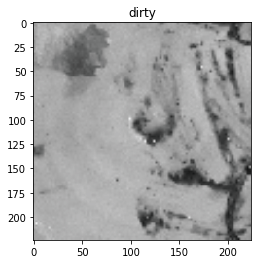

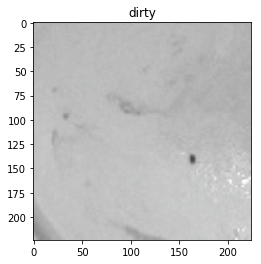

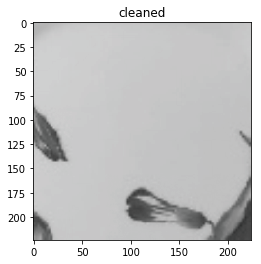

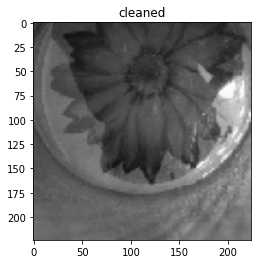

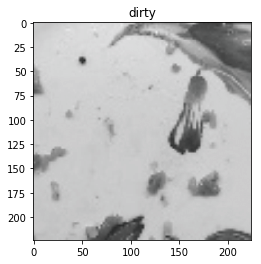

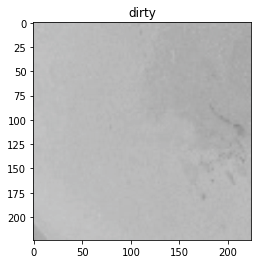

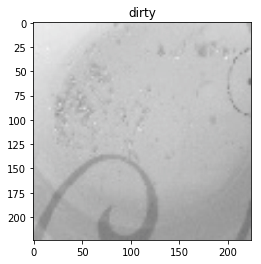

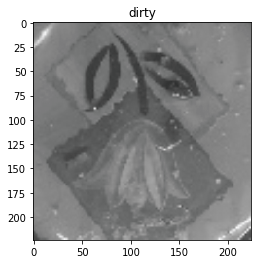

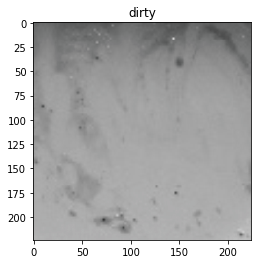

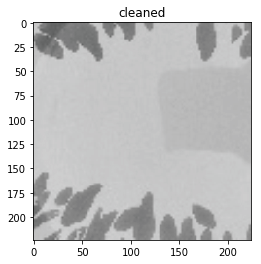

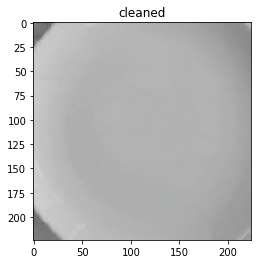

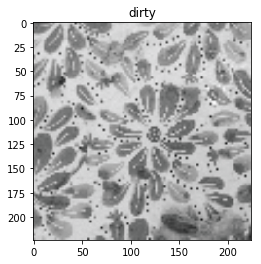

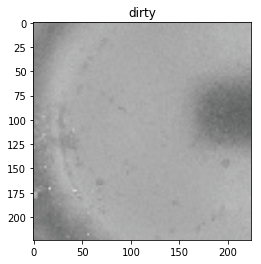

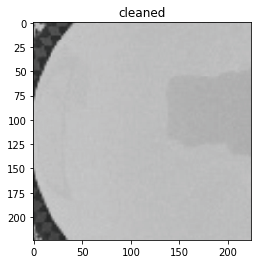

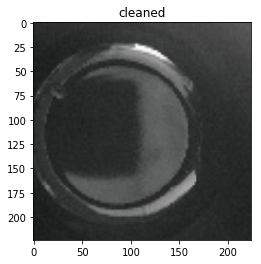

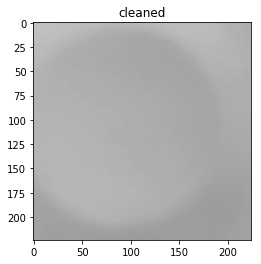

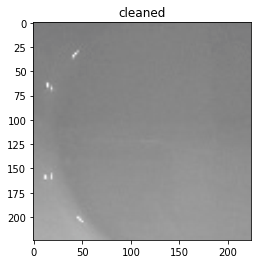

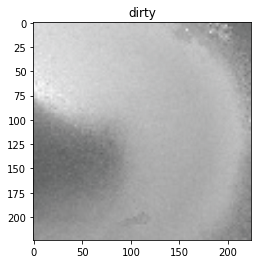

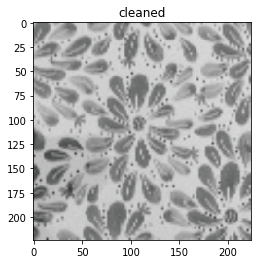

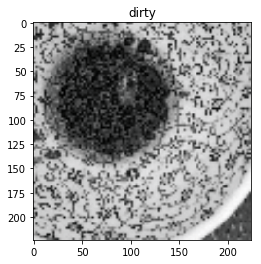

20

In [14]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

i=0
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])
    i+=1
i

In [15]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            #else:
                #dataloader = val_dataloader
                #model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                print(type(labels))
                print(labels)
                labels = labels.to(device)
                break
                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [16]:
model = models.resnet50(pretrained=True)

# Disable grad for all conv layers
#for param in model.parameters():
    #t = param
#    param.requires_grad = False

num_ftrs = model.fc.in_features
#model.bn = torch.nn.BatchNorm1d(num_ftrs)
model.fc = torch.nn.Linear(num_ftrs, 2)    
'''num_ftrs = model.fc.in_features
model.bn = torch.nn.BatchNorm1d(num_ftrs)
model.fc = torch.nn.Linear(num_ftrs, 2)

num_ftrs = model.fc.in_features
model.bn = torch.nn.BatchNorm1d(num_ftrs)
model.fc = torch.nn.Linear(num_ftrs, 2)    
    
model.act = torch.nn.ReLU()
model.fc = torch.nn.Linear(model.fc.in_features, model.fc.in_features)
model.act2 = torch.nn.ReLU()

model.dd = torch.nn.Dropout(p=0.5)

model.act7 = torch.nn.ReLU()
model.fc8 = torch.nn.Linear(model.fc.in_features, model.fc.in_features)
model.act9 = torch.nn.ReLU()

model.dd10 = torch.nn.Dropout(p=0.5)

model.fc2 = torch.nn.Linear(model.fc.in_features, model.fc.in_features)
model.act3 = torch.nn.ReLU()

model.dd2 = torch.nn.Dropout(p=0.5)

model.fc3 = torch.nn.Linear(model.fc.in_features, 100)
model.act4 = torch.nn.ReLU()

model.fc4 = torch.nn.Linear(100, 2)
'''

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-2, amsgrad=True)
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:15<00:00, 6.52MB/s]


In [17]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 1/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 2/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 3/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 4/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 5/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 6/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 7/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 8/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 9/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 10/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 11/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 12/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 13/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 14/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 15/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 16/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 17/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 18/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 19/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 20/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 21/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 22/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 23/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 24/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 25/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 26/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 27/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 28/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 29/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 30/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 31/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 32/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 33/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 34/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 35/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 36/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 37/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 38/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 39/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 40/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 41/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 42/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 43/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 44/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 45/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 46/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 47/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 48/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 49/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 50/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 51/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 52/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 53/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 54/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 55/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 56/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 57/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 58/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 59/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 60/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 61/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 62/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 63/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 64/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 65/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 66/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 67/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 68/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 69/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 70/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 71/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 72/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 73/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 74/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 75/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 76/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 77/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 78/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 79/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 80/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 81/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 82/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 83/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 84/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 85/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 86/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 87/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 88/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 89/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 90/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 91/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 92/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 93/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 94/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 95/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 96/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 97/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 98/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000
Epoch 99/99:



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0])


  0%|          | 0/2 [00:01<?, ?it/s]

val Loss: 0.0000 Acc: 0.0000


In [18]:
#plt.plot(test_accuracy_history, label='test_acc')
#plt.plot(val_accuracy_history, label='val_acc')
#plt.legend()
#plt.title('Accuracy');

In [19]:
#plt.plot(test_loss_history, label='test_loss')
#plt.plot(val_loss_history, label='val_loss')
#plt.legend()
#plt.title('Loss');

In [20]:
#test_dir = 'test'
#shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

In [21]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

NameError: name 'test_dir' is not defined

In [22]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

NameError: name 'test_dataloader' is not defined

In [23]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

NameError: name 'test_dataloader' is not defined

In [24]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [25]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

AttributeError: Can only use .str accessor with string values!

In [26]:
submission_df.to_csv('submission.csv')

In [27]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv

In [28]:
!rm -rf train val test